# General dissimilarity models

Gabriel Munoz  
September 27, 2024

In [ ]:
library(gdm)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

## Load data for this notebook

In [ ]:
temporal_slope <- readRDS("DATA/out/temporal_slope.rds")
temporal_variance <- readRDS('DATA/out/temporal_variance.rds')
spatial_variance <- readRDS('DATA/out/temp_gradients.rds')
mean_temp <- readRDS('DATA/out/mean_temp_stack.rds')



subset_fossil <- readRDS('DATA/out/fossil_data_cleaned.rds')
time_order <- c('Aquitanian', 'Burdigalian', 'Langhian', 'Serravallian', 'Tortonian', 'Messinian', 'Zanclean', 
                "Piacenzian")

## Prepare the site-pair table

In [ ]:
library(sp)
library(sf)

Linking to GEOS 3.11.2, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

terra 1.7.55

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks raster::extract(), terra::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Extract climatic information from raster layers

In [ ]:
fossil_with_env_var <- 
subset_fossil |>
  group_by(midpoint_period)|>
  select(rot_lng, rot_lat, midpoint_period)

fossil_with_env_var <- 
fossil_with_env_var |> 
  group_split() %>%
  setNames(group_keys(fossil_with_env_var)$midpoint_period) |>
  imap(~{

  # extract values (# points auto project to match raster projection)
  t_slope <- raster::extract(temporal_slope[[.y]], .x$geometry |> st_as_sf()) 
  t_var <- raster::extract(temporal_variance[[.y]], .x$geometry |> st_as_sf())
  t_svar <- raster::extract(spatial_variance[[.y]], .x$geometry |> st_as_sf())
  t_mean <- raster::extract(mean_temp[[.y]], .x$geometry |> st_as_sf())

  return(data.frame(t_slope, t_var,t_svar, t_mean))
  
  }) |>
  bind_rows() |> 
  bind_cols(subset_fossil)

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warning in .local(x, y, ...): Transforming SpatialPoints to the crs of the
Raster

Warn

Create the site-pair table

In [ ]:
fossil_with_env_var2 <- 
fossil_with_env_var |>
  group_by(grid_id_5, midpoint_period) |>
  mutate(lat = mean(rot_lat), 
         lon =  mean(rot_lng))  |> 
  mutate(t_slope = mean(t_slope, na.rm = T), 
            t_var = mean(t_var, na.rm = T), 
            t_mean = mean(t_mean, na.rm = T), 
            t_svar = mean(t_svar, na.rm = T)) |>
  ungroup() |>
  group_by(grid_id_5, midpoint_period, GENUS) |> 
  mutate(ab = n_distinct(LIDNUM)) |>
  ungroup()
# biological data 

sppTab <- 
fossil_with_env_var2 |> 
  select(GENUS, grid_id_5, lat, lon, midpoint_period,ab) 
  

# environmental data 
env_data  <- 
fossil_with_env_var2 |> 
  select(starts_with('t_'),lat, lon,grid_id_5, midpoint_period)  


sppTab <- 
sppTab |> 
  group_by(midpoint_period) |>
  group_split()

envTab <- 
env_data |> 
  group_by(midpoint_period) |>
  group_split()

In [ ]:
gdm_models <- 
1:length(sppTab) |>
  map(~{ 
    gdmTab <- formatsitepair(bioData=sppTab[[.x]], 
                         bioFormat=2, #x-y spp list
                         XColumn="lon", 
                         YColumn="lat",
                         sppColumn="GENUS", 
                         siteColumn="grid_id_5",
                         sppFilter = 3,
                         abundColumn =  "ab", 
                         predData=envTab[[.x]])

gdmTab <- gdmTab[complete.cases(gdmTab),]
gdmTab <- gdmTab |>
  select(-matches('midpoint'))

gdm.1 <- gdm(data=gdmTab, geo=TRUE)
  
return(gdm.1)  
    })

Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length
Aggregation function missing: defaulting to length

Extract coefficients and variable contribution

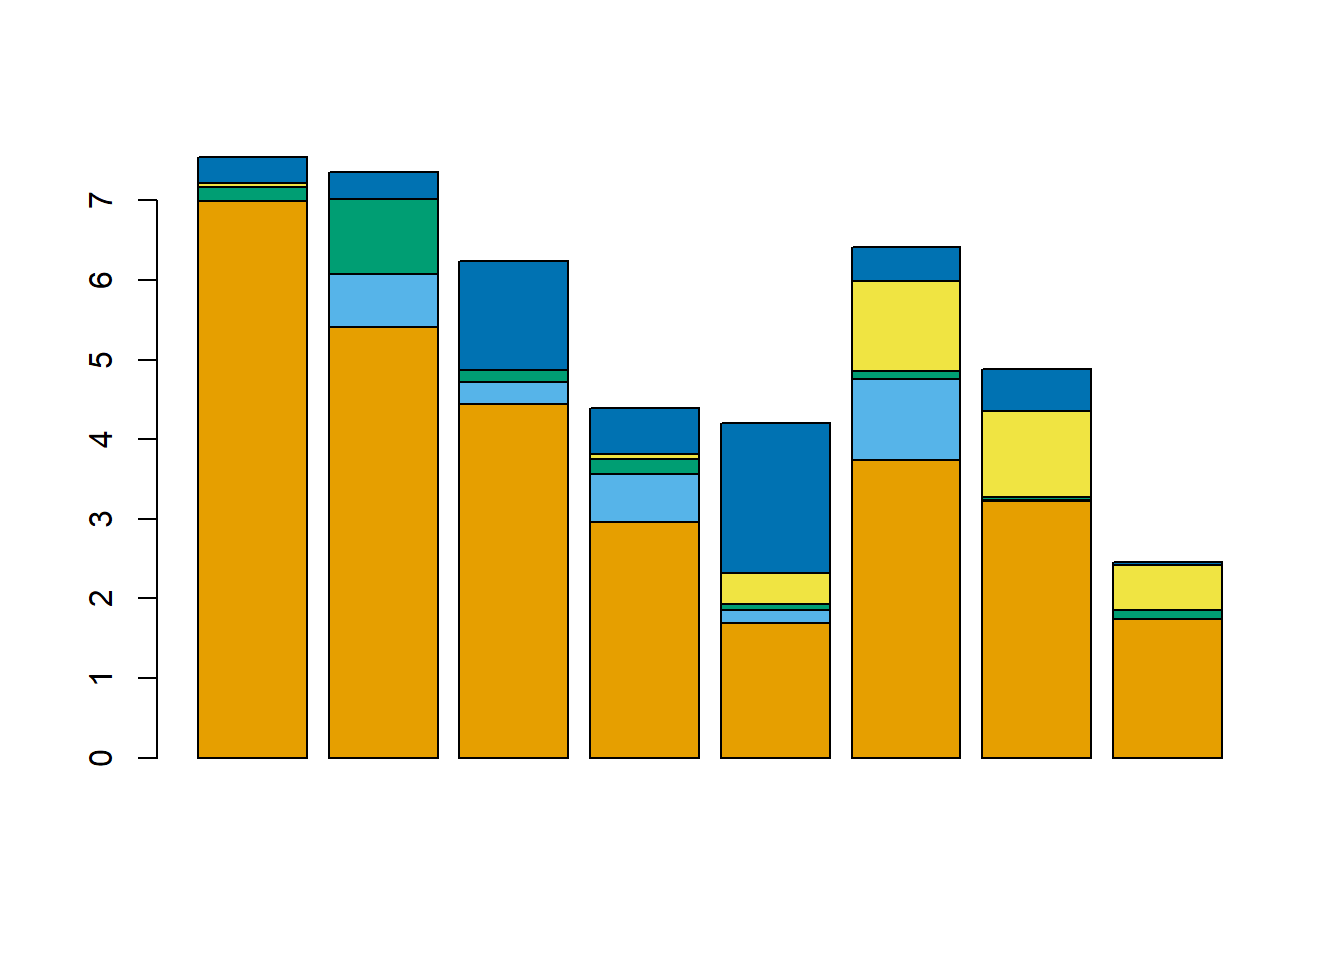

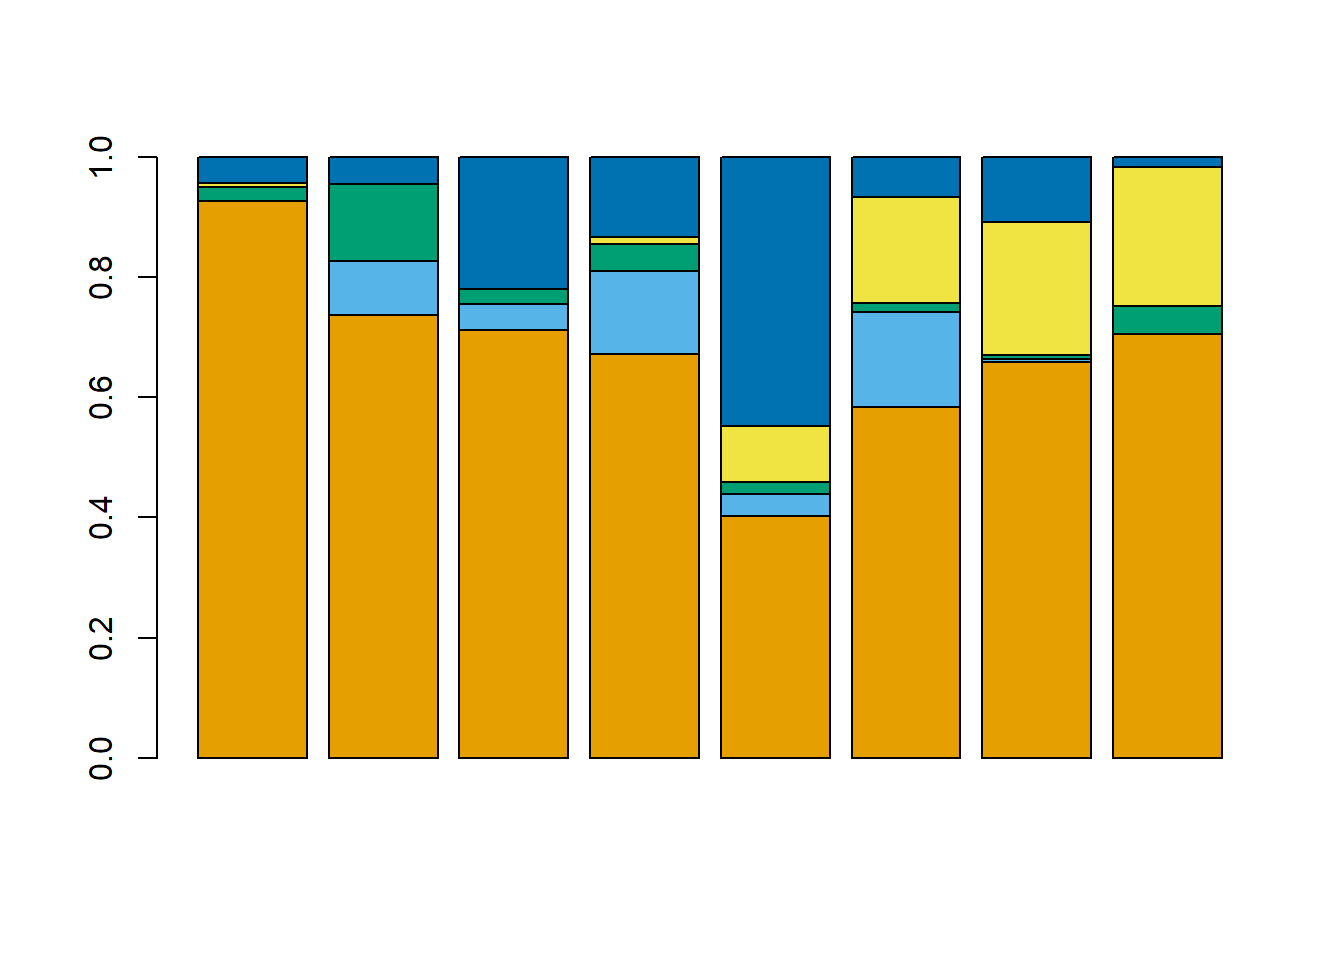

In [ ]:
gdm_coeff <- 
1:8 |> 
  map(~{
    data.frame(t(colSums(matrix(gdm_models[[.x]]$coefficients, c(3,gdm_models[[.x]]$predictors |> length())))))
  })

variable_contribution <-
gdm_coeff |> 
  bind_rows() |>
  setNames(gdm_models[[1]]$predictors)
  


five_colors <- c(
  "#E69F00",  # Geographic
  "#56B4E9",  # t_slope
  "#009E73",  # t_var
  "#F0E442",  # t_svar
  "#0072B2"   # t_mean
)


barplot(as.matrix(t(variable_contribution)),
        col= five_colors)

In [ ]:
rast_trans_all <- 
  1:length(sppTab) |>
  map(~{ 
    raster_all <- stack(temporal_slope[[.x]], temporal_variance[[.x]], spatial_variance[[.x]], mean_temp[[.x]])
    names(raster_all) <- c("Magnitude", 'Temporal variance', 'Spatial variance', 'Mean Temperature')
    
    
    transRasts <- gdm.transform(model=gdm_models[[.x]], data=raster_all)
    
    
    transRasts <- subset(transRasts, c('Magnitude', 'Temporal.variance', 'Spatial.variance', 'Mean.Temperature'))
  })

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in .local(x, ...): invalid layer names omitted

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in .local(x, ...): invalid layer names omitted

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in gdm.transform(model = gdm_models[[.x]], data = raster_all):
Extracted data from rasters contained NAs. These were automatically removed
from the data object to be transformed.

Warning in gdm.transform(model = gdm_models[[.x]], data = ra

Warning in .local(x, ...): invalid layer names omitted

In [ ]:
# Function to convert a single raster layer to a data frame
raster_to_df <- function(rast_layer) {
  df <- as.data.frame(rast_layer, xy = TRUE, na.rm = TRUE)
  colnames(df) <- c("x", "y", "value")
  return(df)
}

# Function to create a ggplot map for a given data frame and layer name
create_map <- function(df, layer_name) {
  ggplot() +
    geom_raster(data = df, aes(x = x, y = y, fill = value)) +
    coord_fixed() +
    scale_fill_viridis_c(name = layer_name, option = "C") +
    theme_minimal() +
    labs(title = layer_name, x = "Longitude", y = "Latitude") +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 12)
    ) 
}

$Temporal.variance

ℹ Consider using `geom_tile()` instead.

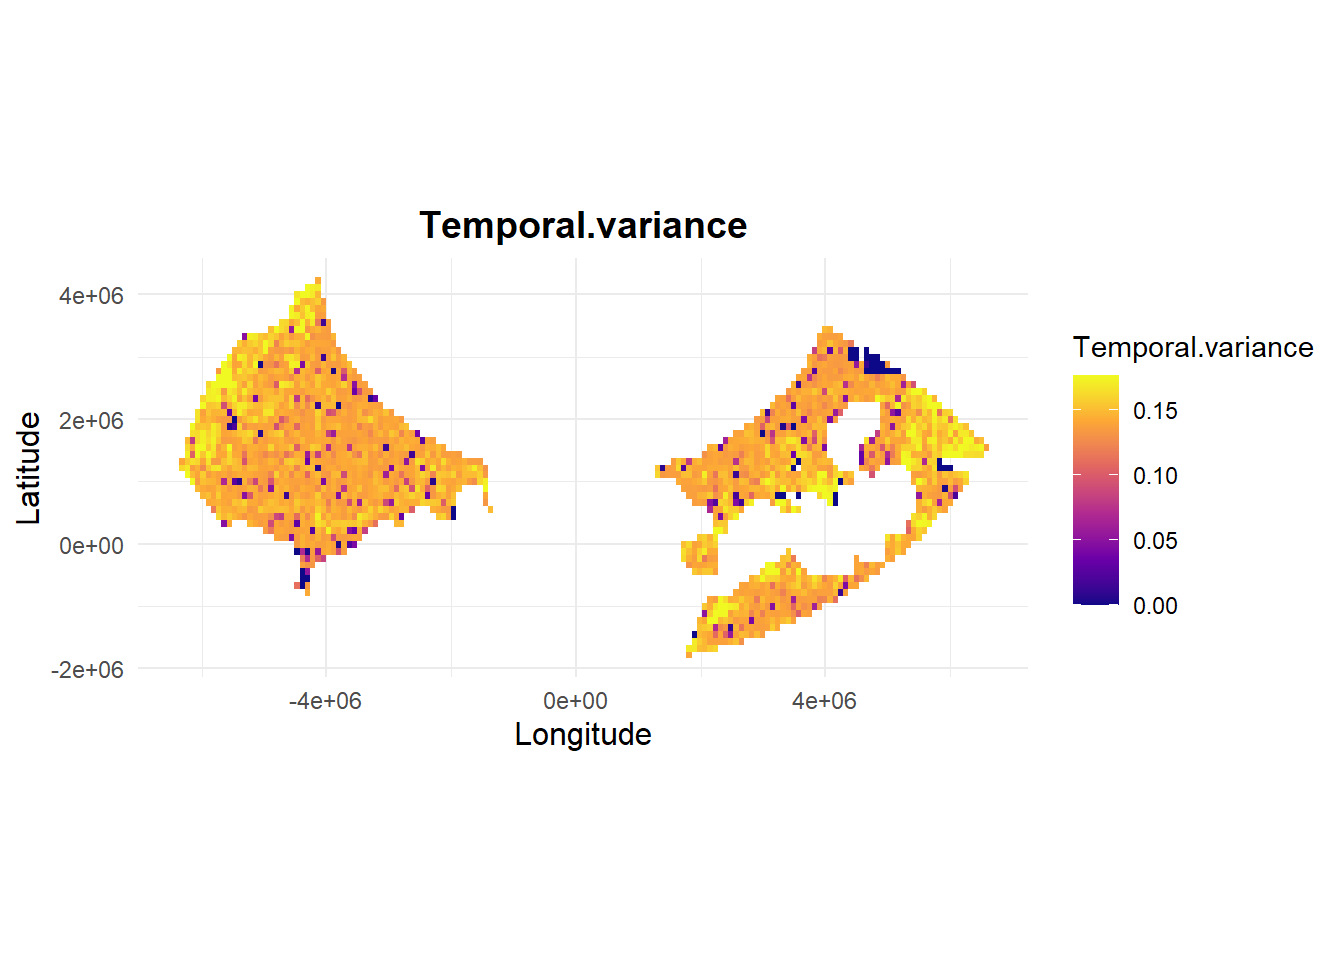


$Spatial.variance

ℹ Consider using `geom_tile()` instead.

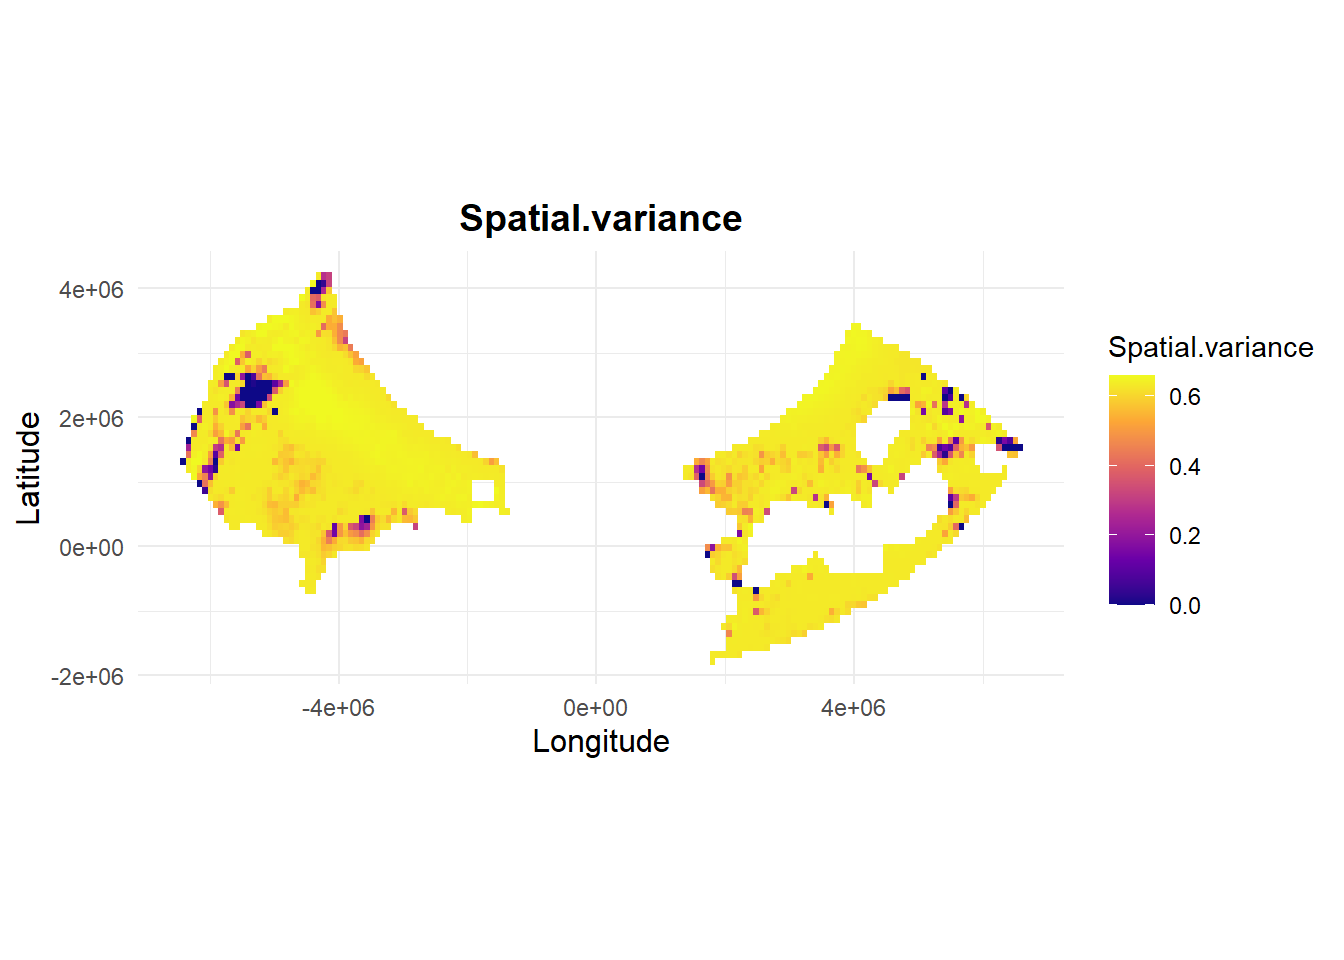


$Mean.Temperature

ℹ Consider using `geom_tile()` instead.

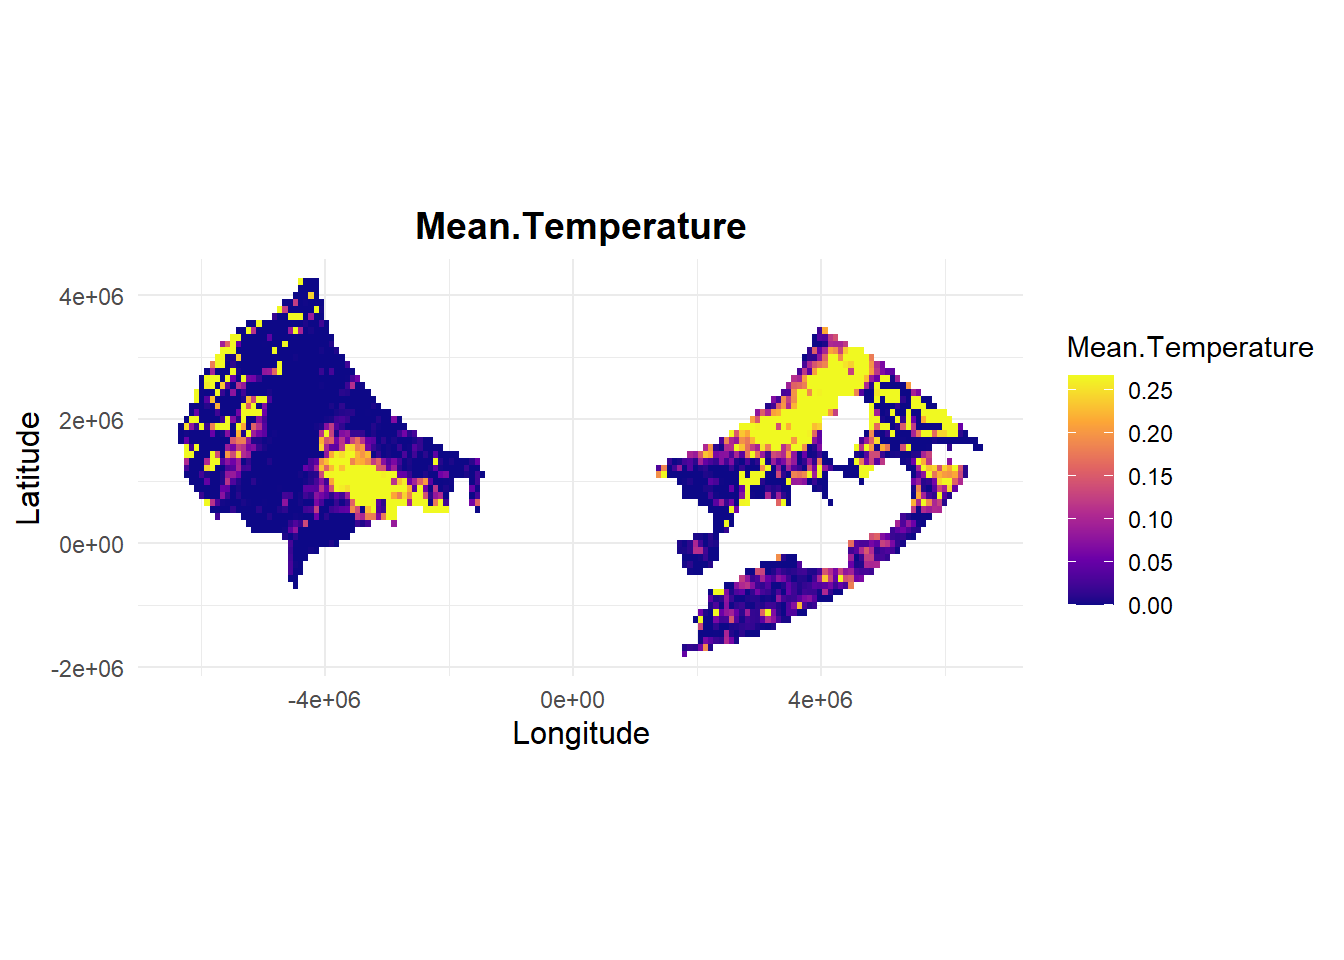

In [ ]:
stage_plots <-

1:8 |>
  map(~{
    # Convert all raster layers to data frames and store in a list
df_list <- lapply(1:nlayers(rast_trans_all[[.x]]), function(i) {
  raster_to_df(rast_trans_all[[i]])
})

# Assign names to the list elements for labeling
names(df_list) <- names(rast_trans_all[[.x]]) 




# Create a list of ggplot maps
plot_list <- mapply(create_map, df_list, names(df_list), SIMPLIFY = FALSE)

    return(plot_list)
  })



stage_plots[[1]]

In [ ]:
extract_trend <- function(raster, var) {
  # Get layer names
  layer_names <- names(raster)
  
  if (var %in% layer_names) {
    # If 'Magnitude' exists, return it
    return(subset(raster, var))
  } else {
 
    return(NULL)
    

  }
}



pred_mean_temperature_stack <- map(rast_trans_all, extract_trend, 'Mean.Temperature')

pred_t_svar_stack <- map(rast_trans_all, extract_trend, 'Spatial.variance')
pred_t_slope_stack <- map(rast_trans_all, extract_trend, 'Magnitude')
pred_t_var_stack <- map(rast_trans_all, extract_trend, 'Temporal.variance')

In [ ]:
MT_agg <- calc(pred_mean_temperature_stack |> stack(), sum, na.rm = TRUE)

TS_agg <- calc( keep(pred_t_slope_stack,~!is.null(.x)) |> stack(), sum, na.rm = TRUE)

T_Svar_agg <- calc(keep(pred_t_svar_stack,~!is.null(.x))  |> stack(), sum, na.rm = TRUE)


T_var_agg <- calc(keep(pred_t_var_stack,~!is.null(.x))  |> stack(), sum, na.rm = TRUE)

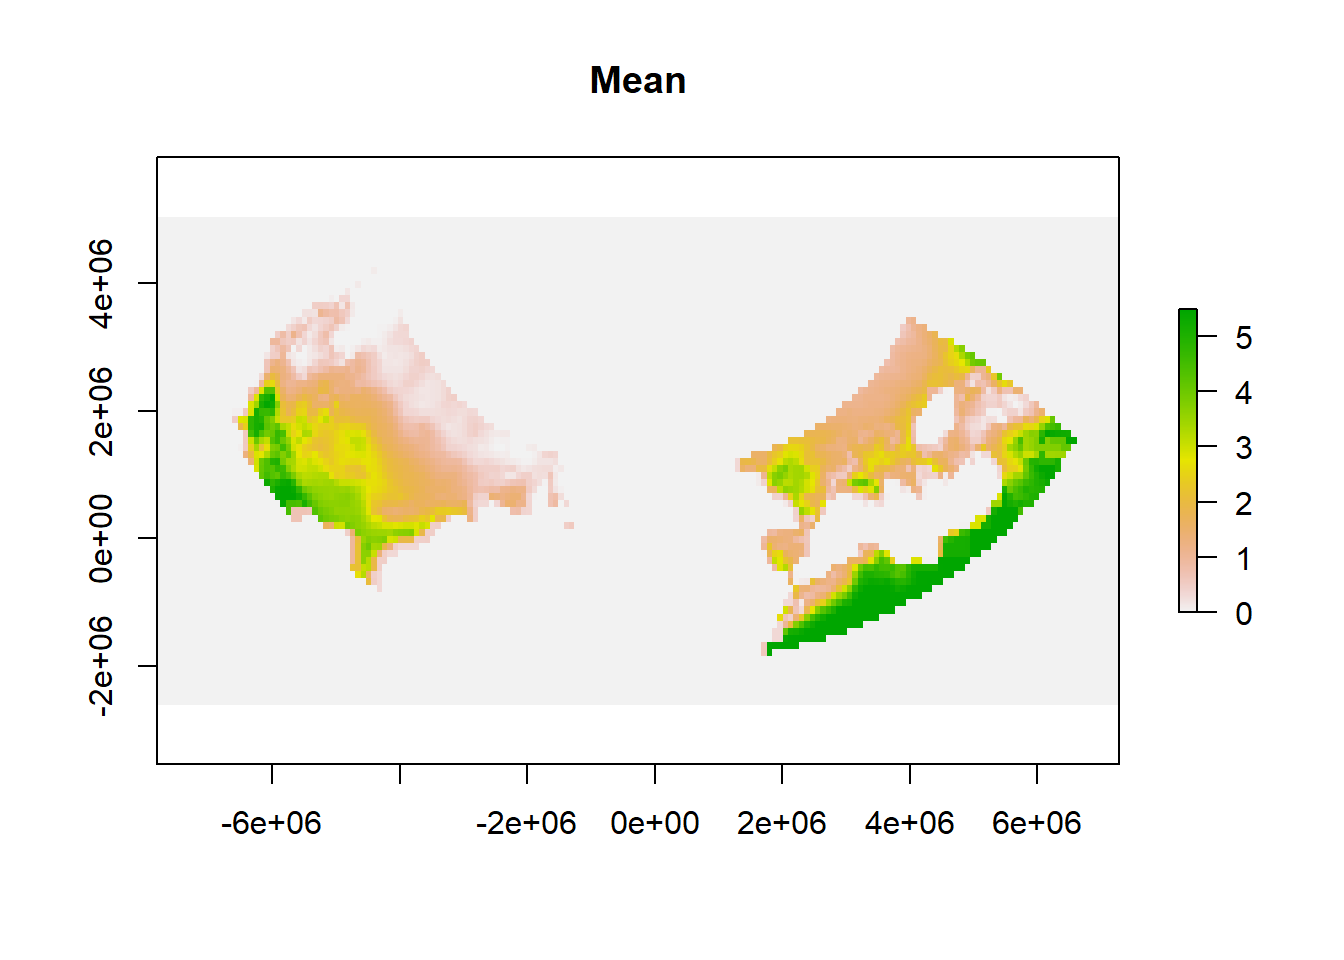

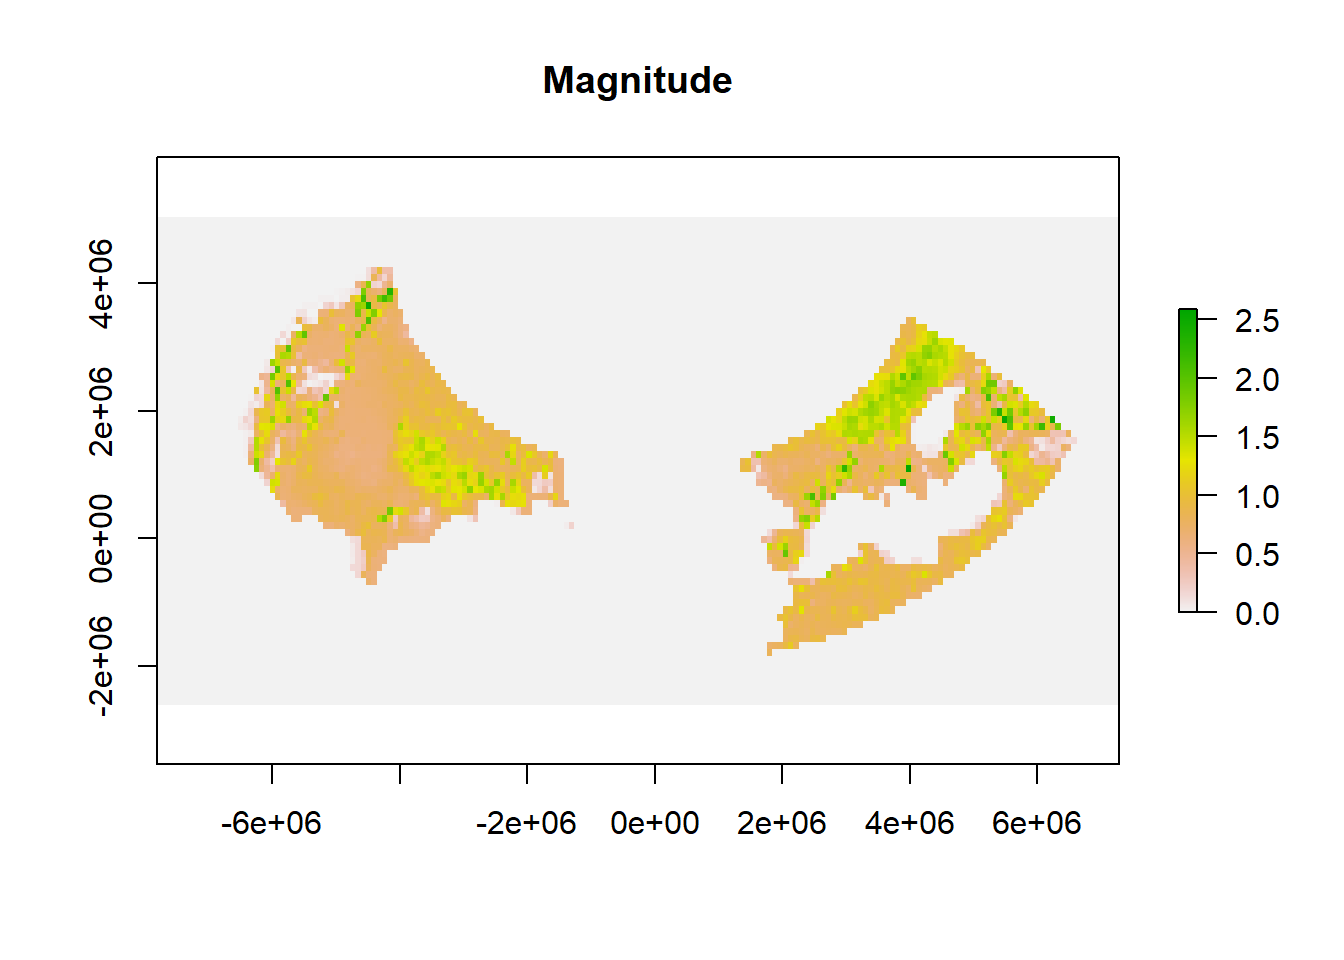

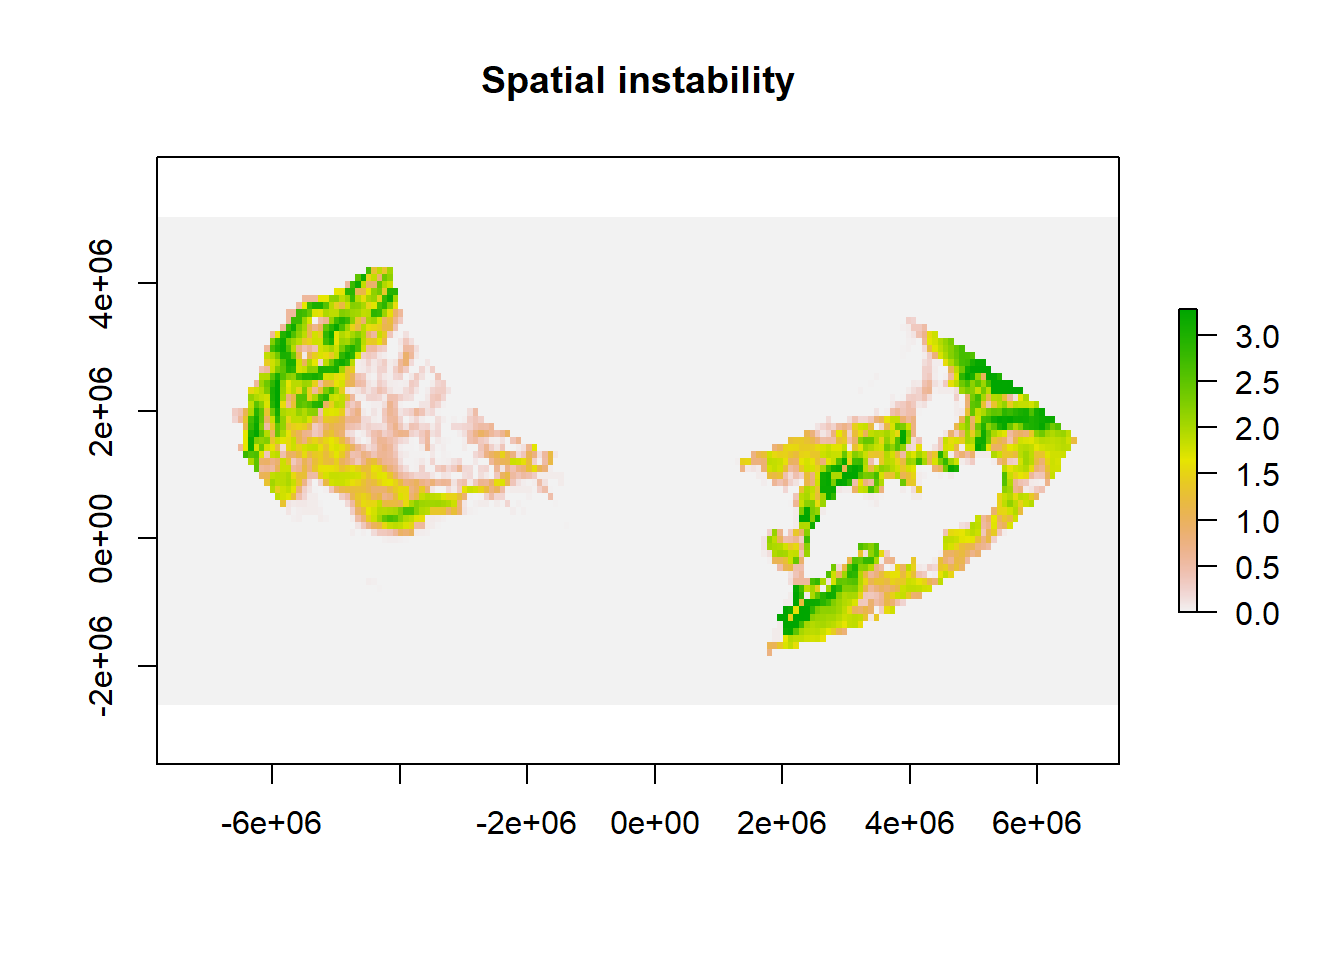

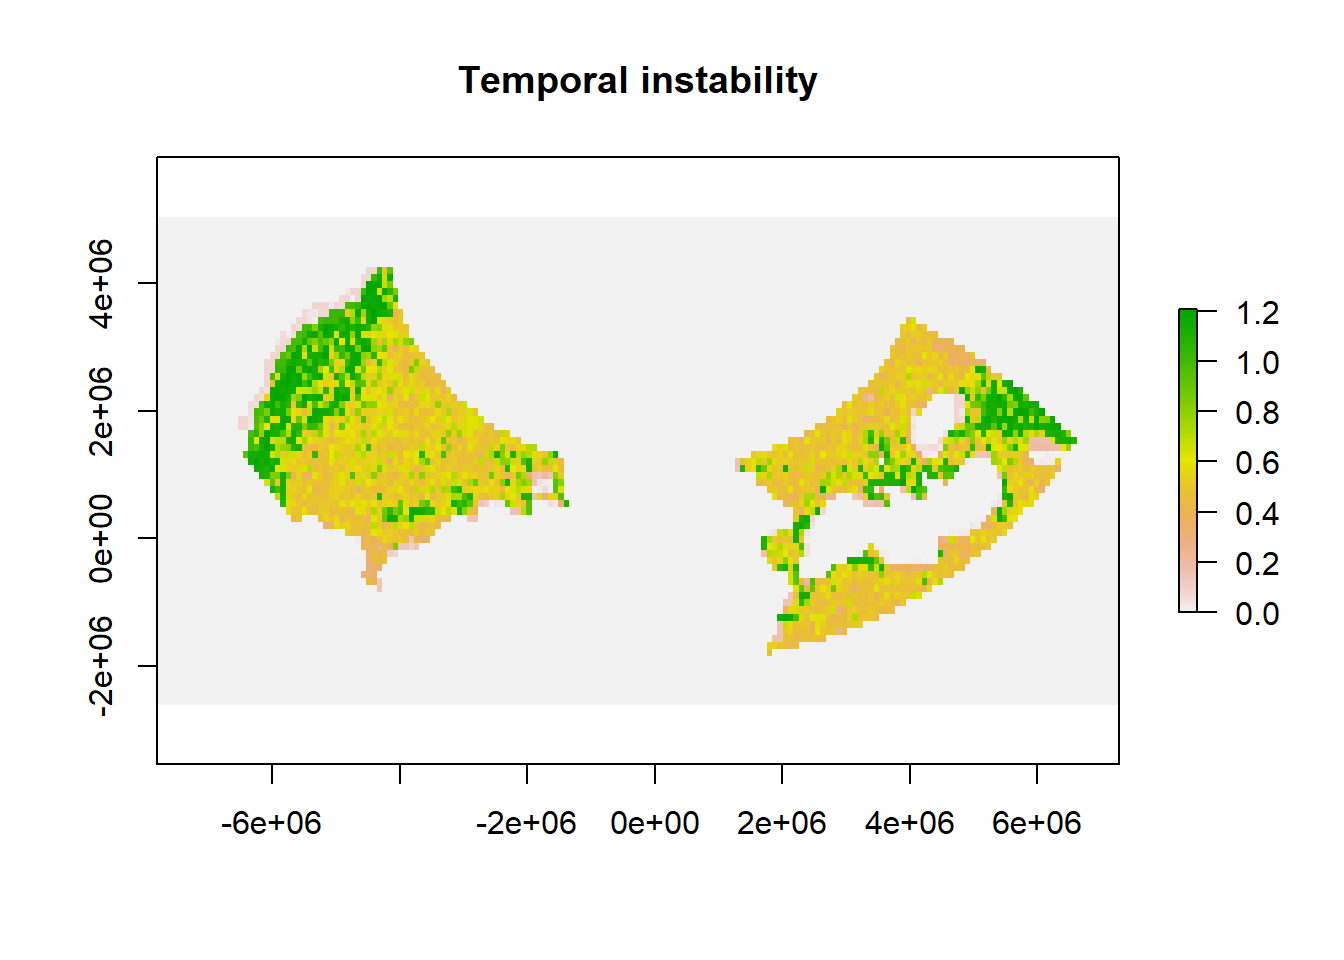

In [ ]:
MT_agg |> plot(main = 'Mean')